In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class SpectralAtmosphere:
    def __init__(self, Lx, Ly, number_of_points_x, number_of_points_y, k_0, W, Cn2, L0, delta_screens):
        self.Lx = Lx # boundary condition: length of grid
        self.Ly = Ly # boundary condition: length of grid
        self.number_of_points_x = number_of_points_x # no of gridpoints on one edge
        self.number_of_points_y = number_of_points_y # no of gridpoints on the other edge
        self.k_0 = k_0 # angular waveumber
        self.W = W # initial radius of the gaussian
        self.Cn2 = Cn2 # Cn2 parameter estimating turbulence
        self.L0 = L0 # outer scale length
        self.delta_screens = delta_screens # distance between phase screens
        
        self.x_grid = np.linspace(-0.5*Lx, 0.5*Lx, number_of_points_x, endpoint=False)
        self.y_grid = np.linspace(-0.5*Ly, 0.5*Ly, number_of_points_y, endpoint=False)
        self.kx_grid = 2 * np.pi * np.fft.fftfreq(number_of_points_x, d=Lx/number_of_points_x)
        self.ky_grid = 2 * np.pi * np.fft.fftfreq(number_of_points_y, d=Ly/number_of_points_y)

        self.X, self.Y = np.meshgrid(self.x_grid, self.y_grid)
        self.Kx, self.Ky = np.meshgrid(self.kx_grid, self.ky_grid)
        
       
        self.D = 1j / (2 * k_0)
        self.epsilon = None
        
    def initialize(self, function):
        self.epsilon = function
        
    def step(self, dz):
        if self.epsilon is None:
            raise ValueError("Initialize epsilon before stepping.")
        
        epsilon_hat = np.fft.fft2(self.epsilon)
        
        epsilon_hat *= np.exp(-self.D * (self.Kx**2 + self.Ky**2) * dz)
        
        self.epsilon = np.fft.ifft2(epsilon_hat)
        
        return self.epsilon
    
    def advance(self, Z, N):
        '''This method does not take turbulence into account'''
        dz = Z / N
        epsilon_evolution = []
        for _ in range(N):
            epsilon_evolution.append(self.step(dz))
        return np.array(epsilon_evolution)
    
    def advance_complete(self, Z, N):
        '''This method takes the Cn2 parameter into account'''
        dz = Z / N
        epsilon_evolution = []
        for i in range(N):
            a = self.step(dz)
            if i * dz % self.delta_screens == 0.: 
                #print("i dz=",i*dz,"phase screen")
                r,r0 = get_power_due_to_change_in_refraction(self)
                a *= np.exp(1j *  np.real(r))
                epsilon_evolution.append(a) 
            else:
                epsilon_evolution.append(a)
            self.epsilon = a    
        return np.array(epsilon_evolution)
    
    
def exponential(spectral):
    return np.exp(-spectral.X**2/spectral.W**2 - spectral.Y**2/spectral.W**2)


In [3]:
def generate_a(kx, ky):
    '''Generation of random numbers for the phase screens'''
    a_prime = np.round(np.random.normal(0, 1, (len(kx), len(ky))))
    a_primeprime = np.round(np.random.normal(0, 1, (len(kx), len(ky))))
    a = (a_prime + 1j * a_primeprime)
    return a

def get_power_due_to_change_in_refraction(spectral):
    '''
    Very high Turbulence: Cn2 = 9e-10
    High Turbulence: Cn2 = 1.7e-11
    Normal Turbulence: Cn2 = 2.1e-14
    
    '''
    k_ = 1/spectral.L0
    dx = spectral.x_grid[1] - spectral.x_grid[0]
    
    N = spectral.kx_grid.shape[0]
    # The f below corresponds to the formula by Martin & Flatte, Appl. Optics 1988
    f = (spectral.k_0)**2  * spectral.delta_screens * 2 * np.pi
    
    psd = 0.033 * spectral.Cn2 * (spectral.Kx**2 + spectral.Ky**2 + k_**2)**(-11/6) * f
    a = generate_a(spectral.kx_grid, spectral.ky_grid)
    
    P0 = np.sqrt(psd) * a
    capital_delta = 2*np.pi/(N * dx)
    P0 *= 1/capital_delta 
    
    P =  np.fft.ifft2(P0)
    P *= 2*np.pi/dx**2 # normalization for units
    
    return P,P0 

def analytical_solution(amp, w, Z, k_0, r):
    '''Analytical solution of the paraxial propagation equation without atmospheric effects for 2D waves. 
    Corresponds to eqn 1 from the report.'''
    Z_R = k_0*w**2/2
    w_z = w*np.sqrt(1+(Z/Z_R)**2)
    R = Z + Z_R**2/Z
    psi = np.arctan(Z/Z_R)
    Er = amp * (w/w_z) *np.exp(-r**2/w_z**2 +1j*k_0*r**2/(2*R) - 1j*psi)
    
    return Er

In [4]:
# Used to propagate the beam in computational space
class PropInComputationalSpace:
    def __init__(self, spectral, width_at_change):        
        self._ = width_at_change
        
        self.X = spectral.X/self._
        self.Y = spectral.Y/self._
        
        self.L = spectral.Lx/self._
        
        self.Kx = spectral.Kx*self._
        self.Ky = spectral.Ky*self._
        
        self.D = 1j / 4
        self.epsilon = None
        
    def initialize(self, function):
        self.epsilon = function
        
    def step(self, dz):
        if self.epsilon is None:
            raise ValueError("Initialize epsilon before stepping.")
        
        epsilon_hat = np.fft.fft2(self.epsilon)
        
        epsilon_hat *= np.exp(-self.D * (self.Kx**2 + self.Ky**2) * dz)
        
        self.epsilon = np.fft.ifft2(epsilon_hat)
        
        return self.epsilon
    
    def advance(self, Z, N):
        dz = Z / N
        epsilon_evolution = []
        for _ in range(N):
            a = self.step(dz)
            phi = 1j * (1 - self.X**2 - self.Y**2) * dz #split step method to guide the wave in its box
            a *= np.exp(phi)
            epsilon_evolution.append(a)
            self.epsilon = a
        return np.array(epsilon_evolution)
    
    def advance_with_absorption_mask(self, Z, N):
        dz = Z / N
        epsilon_evolution = []
        for _ in range(N):
            a = self.step(dz)
            phi = 1j * (1 - self.X**2 - self.Y**2) * dz
            a *= np.exp(phi)
            
            absorption_mask = np.ones_like(a)
            absorption_mask[0:3, :] = np.exp(-1 * (self.X - self.L)**2 *dz)[0:3, :]
            absorption_mask[-3:-1, :] = np.exp(-1 * (self.X + self.L)**2 *dz)[-3:-1, :]
            absorption_mask[-1, :] = np.exp(-1 * (self.X + self.L)**2 *dz)[-1, :]
            absorption_mask[:,0:3] = np.exp(-1 * (self.Y + self.L)**2 *dz)[:,0:3]
            absorption_mask[:, -3:-1] = np.exp(-1 * (self.Y + self.L)**2 *dz)[:, -3:-1]
            absorption_mask[:, -1] = np.exp(-1 * (self.Y + self.L)**2 *dz)[:, -1]
            
            a *= absorption_mask
            epsilon_evolution.append(a)
            self.epsilon = a
        return np.array(epsilon_evolution)
    

In [5]:
def to_computational(function, r, Z, W0, k0):
    '''Change to computational space:
    Z: distance from origin at which you are initiating the change
    r = sqrt(X^2+Y^2)
    W0: initial radius
    k0: angular wavenumber
    
    
    Returns:
    A: in computational space
    wz*W0: value of radius at Z'''
    
    zr = k0 * W0**2 / 2
    wz = np.sqrt(1 + (Z/zr)**2)
    if Z == 0:
        phi=0
    else:
        R = Z + zr**2/Z
        phi = k0 * r**2/(2*R) - np.arctan(Z/zr)
    A = function * wz * np.exp(-1j * phi)
    return A, wz*W0

In [6]:
def to_physical(function, Prop, Z, W0, k0):
    '''
    Prop: the PropInComputationalSpace class object that you are working with
    Z: the total physical distance travelled
    W0: initial beam radius
    k0: angular wavenumber
    '''
    
    Z_r = k_0 * W0**2 / 2
    w_z = np.sqrt(1+Z**2/ Z_r**2)
    
    X = Prop.X * w_z * W0
    Y = Prop.Y * w_z * W0
    
    r2 = X**2 + Y**2

    R = Z + Z_r**2/Z
    phi = r2/(2*R) * k_0 - np.arctan(Z/Z_r)
    
    return function / w_z * np.exp(1j * phi), X, Y

First we propagate a beam straight to the moon without taking into account the atmosphere. The initial radius of the beam is taken to be $0.01m$ in this test:

In [7]:
Lx = 1
Ly = 1
num_xi = 256
W = 0.1
num_z = 1000
k_0 = 2*np.pi/635 *10**9 

Z_r = k_0 * W**2 / 2
Z = 1e8
zeta = np.arctan(Z/Z_r)

In [8]:
spectral = SpectralAtmosphere(Lx, Ly, num_xi, num_xi, k_0, W, Cn2=0, L0=0, delta_screens=0) 
#last three parameters are for atmosphere

In [9]:
init = exponential(spectral)

In [10]:
A, _ = to_computational(init, np.sqrt(spectral.X**2 + spectral.Y**2), Z=0, W0=W, k0=k_0)

In [11]:
prop = PropInComputationalSpace(spectral, _)
prop.initialize(A)
e = prop.advance(zeta, num_z)

Text(0.5, 1.0, 'We see no change in computational space')

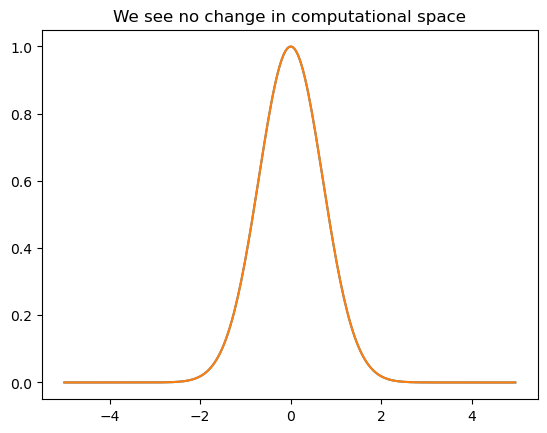

In [12]:
plt.plot(prop.X[128], abs(e[0][128]))
plt.plot(prop.X[128], abs(e[-1][128]))
plt.title('We see no change in computational space')

In [13]:
final, X, Y = to_physical(e[-1], prop, Z = Z, W0 = 0.1, k0=spectral.k_0)

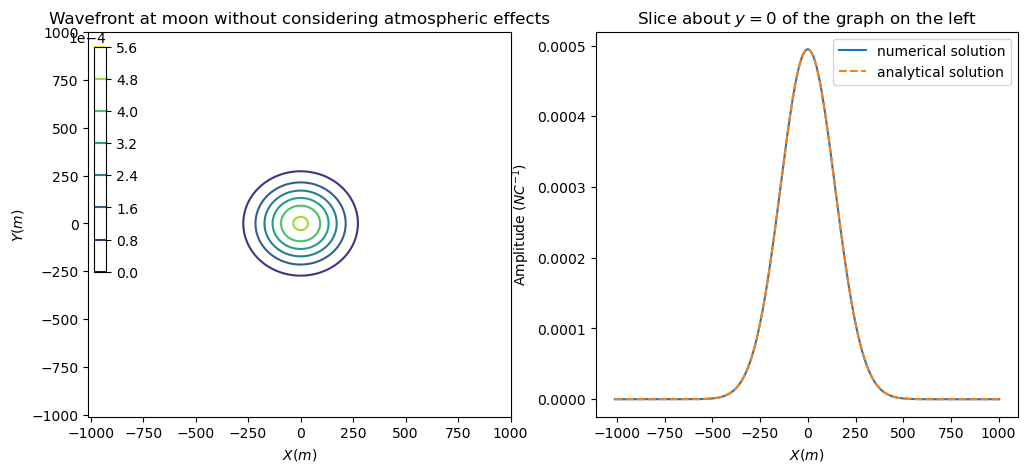

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

im = ax1.contour(X, Y, abs(final))

ax1.set_xlabel(r'$X(m)$')
ax1.set_ylabel(r"$Y(m)$")
ax1.set_title(r'Wavefront at moon without considering atmospheric effects')
cax = fig.add_axes([0.13, 0.4, 0.01, 0.45])

cbar=fig.colorbar(im, cax=cax, orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))

ax2.plot(X[128], abs(final[128]), label='numerical solution')
ax2.set_xlabel(r'$X(m)$')
ax2.set_ylabel(r'Amplitude ($NC^{-1}$)')
ax2.set_title(r'Slice about $y=0$ of the graph on the left')
ax2.plot(X[256//2], abs(analytical_solution(1, 0.1, Z, k_0, X[256//2])), '--', label='analytical solution')
ax2.legend()

We see it is exactly according to the analytical solution: our method is verified

Now, we consider the atmospheric effects.

In [29]:
# Case with the following parameters; a large beam radius taken:

Lx = 3.2
Ly = 3.2
number_of_points_x = 256
number_of_points_y = 256
k_0 =  2*np.pi/635.e-9
Z = 1000 
N = int(2e3)
W = 0.5   
Cn2 = 1e-15
L_0 = 15e-2
delta_screens = 20. 

spectral2 = SpectralAtmosphere(Lx, Ly, number_of_points_x, number_of_points_y, k_0, W, Cn2, L_0, delta_screens)
spectral2.initialize(exponential(spectral2))
epsilon_evolution0 = spectral2.advance_complete(Z, N)


In [30]:
Z = 8000
N = int(3e3)
Cn2 = 1.e-17
spectral2.Cn2 = Cn2
epsilon_evolution2 = spectral2.advance_complete(Z, N)

In [31]:
Z = 16000
N = int(3e3)
Cn2 = 1.e-18
spectral2.Cn2 = Cn2
epsilon_evolution2 = spectral2.advance_complete(Z, N)

In [32]:
# checking if Parseval equality is satisfied

w,w0 = get_power_due_to_change_in_refraction(spectral2)
dx=spectral2.x_grid[1]-spectral2.x_grid[0]
dy=spectral2.y_grid[1]-spectral2.y_grid[0]
dkx=spectral2.kx_grid[1]
dky=spectral2.ky_grid[1]
I1=np.sum(abs(w)**2 ) *dx*dy
I2=np.sum(abs(w0)**2 )*dkx*dky
print(I1, I2)
print(I1/I2)

3.6983618977661974e-05 3.69836189776617e-05
1.0000000000000073


Text(0, 0.5, '$Y(m)$')

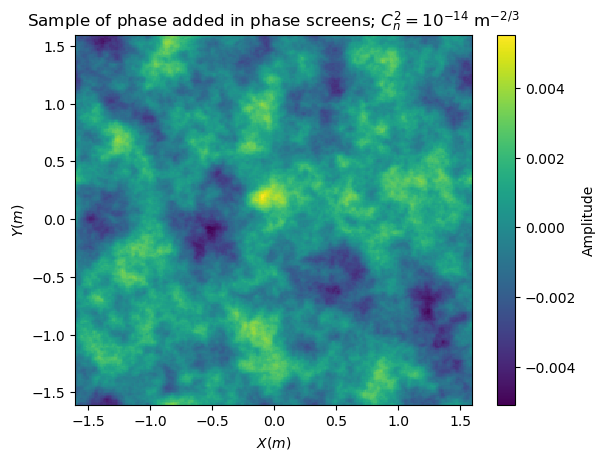

In [43]:
plt.pcolormesh(spectral2.X, spectral2.Y, np.real(w))
plt.colorbar(label='Amplitude')
plt.title(r'Sample of phase added in phase screens; $C_n^2 = 10^{-14}$ m$^{-2/3}$')
plt.xlabel(r'$X(m)$')
plt.ylabel(r'$Y(m)$')

Text(0.5, 1.0, 'Wavefront at $Z=25$ km')

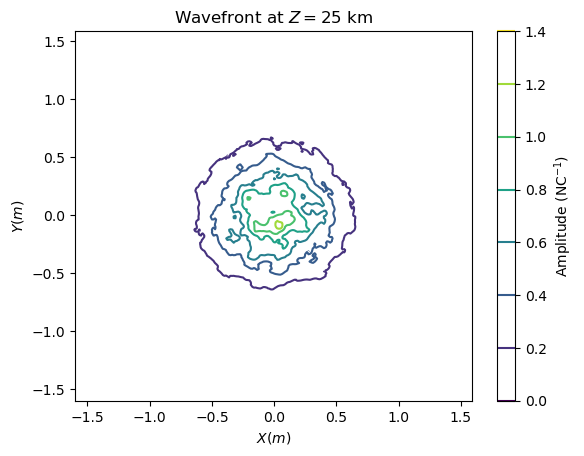

In [44]:
plt.contour(spectral2.X, spectral2.Y, abs(epsilon_evolution2[-1]))
plt.colorbar(label=r'Amplitude (NC$^{-1}$)')
plt.xlabel(r'$X(m)$')
plt.ylabel(r"$Y(m)$")
plt.title(r'Wavefront at $Z=25$ km')

Text(0, 0.5, '$Y(m)$')

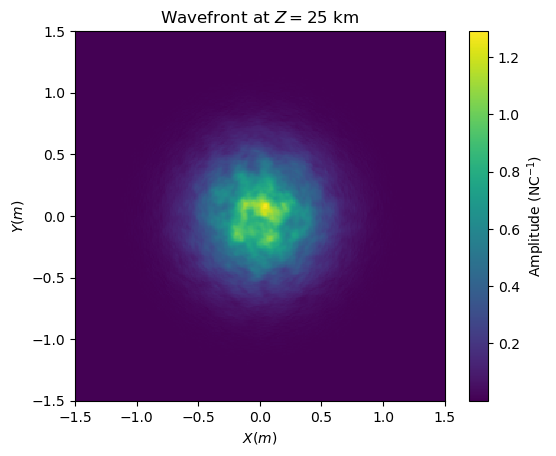

In [45]:
plt.imshow(abs(epsilon_evolution2[-1]), interpolation='None', extent=[-1.5, 1.5,-1.5,1.5])
cm = plt.colorbar(label=r'Amplitude (NC$^{-1}$)')
plt.title(r'Wavefront at $Z=25$ km')
plt.xlabel(r'$X(m)$')
plt.ylabel(r"$Y(m)$")


In [46]:
A, _ = to_computational(epsilon_evolution2[-1], np.sqrt(spectral2.X**2 + spectral2.Y**2), Z=25000, W0=0.5, k0=spectral2.k_0)

In [47]:
num_z = 500
Z_r = k_0 * W**2 / 2
Zpr = 3.5e8
zeta = np.arctan(Zpr/Z_r)

prop = PropInComputationalSpace(spectral2, _)

In [48]:
prop.initialize(A)

In [49]:
e = prop.advance_with_absorption_mask(zeta, num_z)

Text(0.5, 1.0, 'In Computational Space')

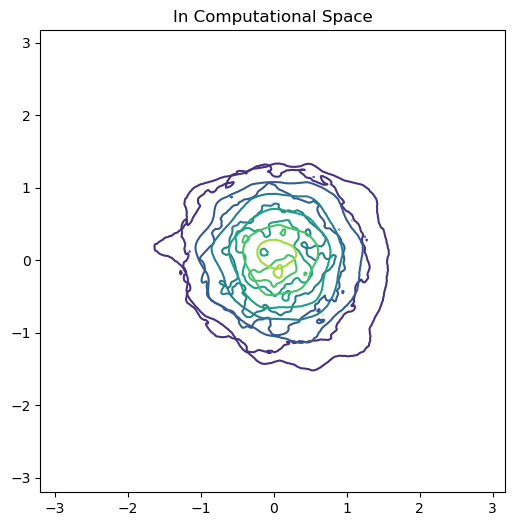

In [50]:
plt.figure(figsize=(6,6))
plt.contour(prop.X, prop.Y, abs(e[0]))

plt.contour(prop.X, prop.Y, abs(e[-1]))
plt.title('In Computational Space')

In [51]:
final, X, Y = to_physical(e[-1], prop, 25000+Zpr, W0=0.5, k0=spectral2.k_0)

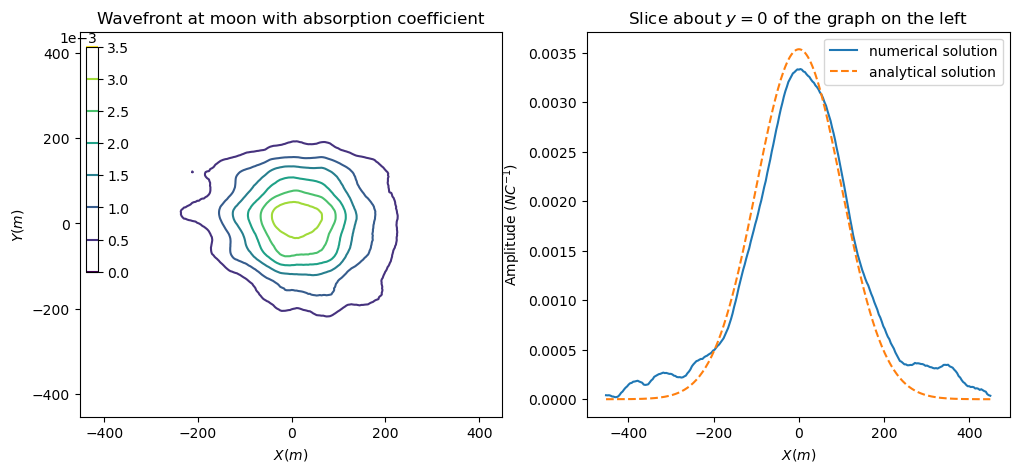

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

im = ax1.contour(X, Y, abs(final))#$w = 0.5~$m, $E_0 = 1$')

ax1.set_xlabel(r'$X(m)$')
ax1.set_ylabel(r"$Y(m)$")
ax1.set_title(r'Wavefront at moon with absorption coefficient')
cax = fig.add_axes([0.13, 0.4, 0.01, 0.45])

cbar=fig.colorbar(im, cax=cax, orientation='vertical')
cbar.formatter.set_powerlimits((0, 0))

ax2.plot(X[128], abs(final[128]), label='numerical solution')
ax2.set_xlabel(r'$X(m)$')
ax2.set_ylabel(r'Amplitude ($NC^{-1}$)')
ax2.set_title(r'Slice about $y=0$ of the graph on the left')
ax2.plot(X[256//2], abs(analytical_solution(1, 0.5, 25000+Zpr, k_0, X[256//2])), '--', label='analytical solution')
ax2.legend()

Note that the results shown here and in the report may be different due to the random nature of turbulence